# Levelset Segmentation <a href="https://mybinder.org/v2/gh/InsightSoftwareConsortium/SimpleITK-Notebooks/master?filepath=Python%2F31_Levelset_Segmentation.ipynb"><img style="float: right;" src="https://mybinder.org/badge_logo.svg"></a>


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import SimpleITK as sitk
from myshow import myshow, myshow3d

In [2]:
img_T1 = sitk.ReadImage("./604.000000-COR 3X3-11320_resampled.mha")
img_T1_255 = sitk.Cast(sitk.RescaleIntensity(img_T1), sitk.sitkUInt8)

In [3]:
%env SITK_SHOW_COMMAND /Applications/ITK-SNAP.app/Contents/MacOS/ITK-SNAP 
sitk.Show(img_T1, title="T1")

env: SITK_SHOW_COMMAND=/Applications/ITK-SNAP.app/Contents/MacOS/ITK-SNAP


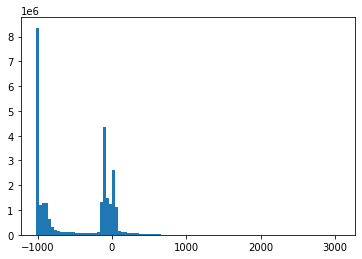

In [4]:
plt.figure()
plt.hist(sitk.GetArrayViewFromImage(img_T1).flatten(), bins=100)
plt.show()

In [5]:
img_T1.GetSize()

(512, 512, 106)

In [6]:
idx = tuple(v - 1 for v in img_T1.GetSize())
print(idx)
pt = img_T1.TransformIndexToPhysicalPoint(idx)

(511, 511, 105)


libpng warning: sCAL: invalid unit
libpng warning: sCAL: invalid unit
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: sCAL: invalid unit
libpng warning: sCAL: invalid unit
FALLBACK (log once): Fallback to SW vertex for line stipple
FALLBACK (log once): Fallback to SW vertex processing, m_disable_code: 2000
FALLBACK (log once): Fallback to SW vertex processing in drawCore, m_disable_code: 2000


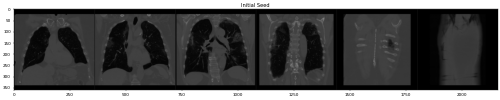

In [7]:
seg = sitk.Image(img_T1.GetSize(), sitk.sitkUInt8)
seg.CopyInformation(img_T1)
seg[idx] = 1
seg = sitk.BinaryDilate(seg, [3] * 3)
myshow3d(
    sitk.LabelOverlay(img_T1_255, seg),
    zslices=range(int(idx[2]/2), idx[2], 10),
    dpi=30,
    title="Initial Seed",
)

In [8]:
stats = sitk.LabelStatisticsImageFilter()
stats.Execute(img_T1, seg)
print(stats)

itk::simple::LabelStatisticsImageFilter
  UseHistograms: 1
  Labels: [ 1, 0 ]
  Debug: 0
  NumberOfThreads: 8
  NumberOfWorkUnits: 0
  Commands: (none)
  ProgressMeasurement: 0
  ActiveProcess:
    LabelStatisticsImageFilter (0x124214210)
      RTTI typeinfo:   itk::LabelStatisticsImageFilter<itk::Image<int, 3u>, itk::Image<unsigned char, 3u> >
      Reference Count: 1
      Modified Time: 3236
      Debug: Off
      Object Name: 
      Observers: 
        DeleteEvent(FunctionCommand)
      Inputs: 
        LabelInput: (0x124e60230) *
        Primary: (0x1133abe40) *
      Indexed Inputs: 
        0: Primary (0x1133abe40)
      Required Input Names: LabelInput, Primary
      NumberOfRequiredInputs: 1
      Outputs: 
        Primary: (0x0)
      Indexed Outputs: 
        0: Primary (0x0)
      NumberOfRequiredOutputs: 0
      Number Of Work Units: 8
      ReleaseDataFlag: Off
      ReleaseDataBeforeUpdateFlag: On
      AbortGenerateData: Off
      Progress: 1
      Multithreader: 
     

In [9]:
factor = 1.5
print(f'mean={stats.GetMean(1)}')
lower_threshold = stats.GetMean(1) - factor * stats.GetSigma(1)
upper_threshold = stats.GetMean(1) + factor * stats.GetSigma(1)
print(f'lower_threshold={lower_threshold}')
print(f'upper_threshold={upper_threshold}')

mean=-682.6666666666666
lower_threshold=-1416.2094756639187
upper_threshold=50.87614233058548


In [10]:
init_ls = sitk.SignedMaurerDistanceMap(seg, insideIsPositive=True, useImageSpacing=True)

In [11]:
lsFilter = sitk.ThresholdSegmentationLevelSetImageFilter()
lsFilter.SetLowerThreshold(lower_threshold)
lsFilter.SetUpperThreshold(upper_threshold)
lsFilter.SetMaximumRMSError(0.02)
lsFilter.SetNumberOfIterations(100)
lsFilter.SetCurvatureScaling(1)
lsFilter.SetPropagationScaling(1)
lsFilter.ReverseExpansionDirectionOn()
ls = lsFilter.Execute(init_ls, sitk.Cast(img_T1, sitk.sitkFloat32))
print(lsFilter)

itk::simple::ThresholdSegmentationLevelSetImageFilter
  LowerThreshold: -1416.21
  UpperThreshold: 50.8761
  MaximumRMSError: 0.02
  PropagationScaling: 1
  CurvatureScaling: 1
  NumberOfIterations: 100
  ReverseExpansionDirection: 1
  ElapsedIterations: 100
  RMSChange: 0.0704284
  Debug: 0
  NumberOfThreads: 8
  NumberOfWorkUnits: 0
  Commands: (none)
  ProgressMeasurement: 1
  ActiveProcess: (none)



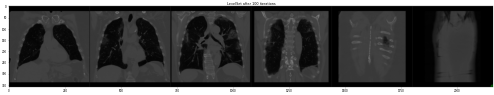

In [12]:
zslice_offset = 4
t = "LevelSet after " + str(lsFilter.GetNumberOfIterations()) + " iterations"
myshow3d(
    sitk.LabelOverlay(img_T1_255, ls > 0),
    zslices=range(int(idx[2]/2), idx[2], 10),
    dpi=20,
    title=t,
)

Return code : 0


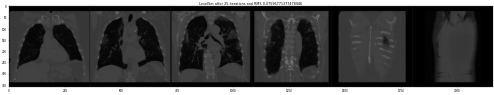

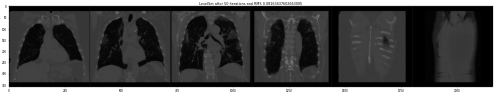

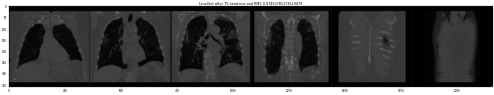

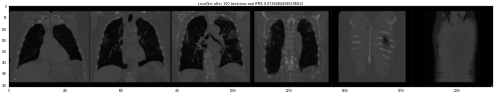

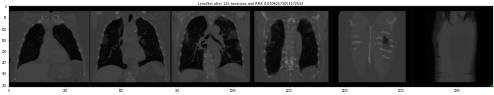

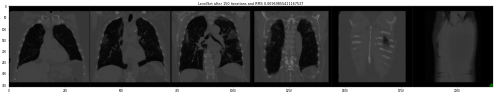

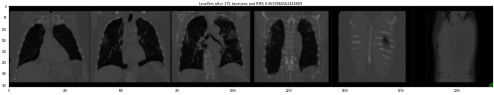

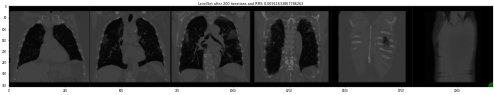

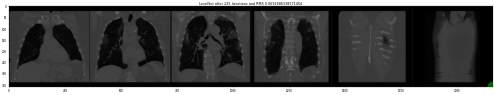

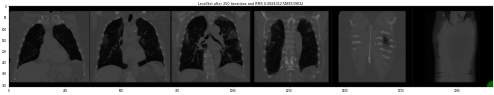

In [13]:
lsFilter.SetNumberOfIterations(25)
img_T1f = sitk.Cast(img_T1, sitk.sitkFloat32)
ls = init_ls
niter = 0
for i in range(0, 10):
    ls = lsFilter.Execute(ls, img_T1f)
    niter += lsFilter.GetNumberOfIterations()
    t = (
        "LevelSet after "
        + str(niter)
        + " iterations and RMS "
        + str(lsFilter.GetRMSChange())
    )
    fig = myshow3d(
        sitk.LabelOverlay(img_T1_255, ls > 0),
        zslices=range(int(idx[2]/2), idx[2], 10),
        dpi=20,
        title=t,
    )